In [1]:
# ================== INSTALL DEPENDENCIES ==================
!pip install rdkit -q
print("✅ RDKit installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 27.2 MB/s eta 0:00:00
✅ RDKit installed successfully!


In [2]:
# ================== SETUP & IMPORTS ==================
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from rdkit import Chem, rdBase, RDLogger
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen, Lipinski, Fragments, AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.MACCSkeys import GenMACCSKeys
from rdkit.Chem.AllChem import ComputeGasteigerCharges
from joblib import Parallel, delayed
from functools import lru_cache
from tqdm import tqdm

RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("✅ All imports successful!")

✅ All imports successful!


In [3]:
# ================== LOAD DATA ==================
print("Loading datasets...")
df_train = pd.read_csv("/kaggle/input/melting-point/train.csv")[['SMILES', 'Tm']]
df_test = pd.read_csv("/kaggle/input/melting-point/test.csv")[['id', 'SMILES']]
sample_submission = pd.read_csv("/kaggle/input/melting-point/sample_submission.csv")

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

Loading datasets...
Train shape: (2662, 2)
Test shape: (666, 2)
Sample submission shape: (666, 2)


In [4]:
# ================== CANONICALIZATION ==================
def canonicalize(smile):
    try:
        mol = Chem.MolFromSmiles(smile)
        return Chem.MolToSmiles(mol, canonical=True) if mol else None
    except:
        return None

print("Canonicalizing SMILES...")
df_train['SMILES'] = df_train['SMILES'].apply(canonicalize)
df_test['SMILES'] = df_test['SMILES'].apply(canonicalize)

df_train.drop_duplicates(subset='SMILES', keep='last', inplace=True)
df_train.dropna(inplace=True)
df_test.dropna(subset=['SMILES'], inplace=True)

print(f"Training data: {len(df_train)} samples")
print(f"Test data: {len(df_test)} samples")

Canonicalizing SMILES...
Training data: 2660 samples
Test data: 666 samples


In [5]:
# ================== FEATURE ENGINEERING ==================
MORGAN_BITS = 1024
MORGAN_RADIUS = 3
USE_MACCS = True

def _safe(f, default=None):
    def wrap(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return default
    return wrap

def extract_features(mol):
    """Extract comprehensive molecular features"""
    if mol is None:
        return {}
    
    features = {}
    
    # Basic descriptors
    features['MolWt'] = _safe(Descriptors.MolWt, 0)(mol)
    features['LogP'] = _safe(Crippen.MolLogP, 0)(mol)
    features['TPSA'] = _safe(rdMolDescriptors.CalcTPSA, 0)(mol)
    features['NumHDonors'] = _safe(Lipinski.NumHDonors, 0)(mol)
    features['NumHAcceptors'] = _safe(Lipinski.NumHAcceptors, 0)(mol)
    features['NumRotatableBonds'] = _safe(rdMolDescriptors.CalcNumRotatableBonds, 0)(mol)
    features['NumAromaticRings'] = _safe(rdMolDescriptors.CalcNumAromaticRings, 0)(mol)
    features['NumAliphaticRings'] = _safe(rdMolDescriptors.CalcNumAliphaticRings, 0)(mol)
    features['NumSaturatedRings'] = _safe(rdMolDescriptors.CalcNumSaturatedRings, 0)(mol)
    features['NumRings'] = _safe(rdMolDescriptors.CalcNumRings, 0)(mol)
    features['FractionCSP3'] = _safe(rdMolDescriptors.CalcFractionCSP3, 0)(mol)
    features['HeavyAtomCount'] = mol.GetNumHeavyAtoms()
    features['NumHeteroatoms'] = _safe(Lipinski.NumHeteroatoms, 0)(mol)
    features['MolMR'] = _safe(Crippen.MolMR, 0)(mol)
    
    # Ring info
    features['NumBridgeheadAtoms'] = _safe(rdMolDescriptors.CalcNumBridgeheadAtoms, 0)(mol)
    features['NumSpiroAtoms'] = _safe(rdMolDescriptors.CalcNumSpiroAtoms, 0)(mol)
    
    # Charge features
    try:
        mol_h = Chem.AddHs(mol)
        ComputeGasteigerCharges(mol_h)
        charges = [a.GetDoubleProp('_GasteigerCharge') if a.HasProp('_GasteigerCharge') else 0 
                   for a in mol_h.GetAtoms()]
        charges = np.array([c if not np.isnan(c) and np.isfinite(c) else 0 for c in charges])
        features['Charge_Mean'] = float(np.mean(charges))
        features['Charge_Std'] = float(np.std(charges))
        features['Charge_Max'] = float(np.max(charges))
        features['Charge_Min'] = float(np.min(charges))
    except:
        features.update({'Charge_Mean': 0, 'Charge_Std': 0, 'Charge_Max': 0, 'Charge_Min': 0})
    
    # Fragment counts
    for frag_name in ['fr_benzene', 'fr_phenol', 'fr_ester', 'fr_ether', 
                      'fr_aldehyde', 'fr_ketone', 'fr_NH2', 'fr_NH1', 'fr_NH0',
                      'fr_COO', 'fr_C_O', 'fr_methoxy', 'fr_nitro']:
        frag_func = getattr(Fragments, frag_name, None)
        if frag_func:
            features[frag_name] = _safe(frag_func, 0)(mol)
    
    # Morgan Fingerprints
    try:
        mgen = rdFingerprintGenerator.GetMorganGenerator(radius=MORGAN_RADIUS, fpSize=MORGAN_BITS)
        mfp = mgen.GetFingerprint(mol)
        for i in range(MORGAN_BITS):
            features[f'Morgan_{i}'] = int(mfp[i])
    except:
        for i in range(MORGAN_BITS):
            features[f'Morgan_{i}'] = 0
    
    # MACCS Keys
    if USE_MACCS:
        try:
            maccs = GenMACCSKeys(mol)
            for i in range(len(maccs)):
                features[f'MACCS_{i}'] = int(maccs[i])
        except:
            for i in range(167):
                features[f'MACCS_{i}'] = 0
    
    # Interaction features
    hat = features['HeavyAtomCount'] if features['HeavyAtomCount'] > 0 else 1
    features['HBondCapacity'] = features['NumHDonors'] + features['NumHAcceptors']
    features['HBondDensity'] = features['HBondCapacity'] / hat
    features['RingDensity'] = features['NumRings'] / hat
    features['AromaticFrac'] = features['NumAromaticRings'] / max(features['NumRings'], 1)
    features['Flexibility'] = features['NumRotatableBonds'] / max(features['MolWt'], 1)
    features['LogP_TPSA_Ratio'] = features['LogP'] / max(features['TPSA'], 1)
    features['MW_x_AromaticRings'] = features['MolWt'] * features['NumAromaticRings']
    features['Rigidity'] = features['NumAromaticRings'] / max(features['NumRotatableBonds'], 1)
    features['Polarity_Index'] = (features['NumHDonors'] + features['NumHAcceptors']) * features['TPSA']
    
    return features

def featurize_batch(smiles_list, batch_size=500):
    """Batch processing for memory efficiency"""
    all_features = []
    for i in tqdm(range(0, len(smiles_list), batch_size), desc="Featurizing"):
        batch = smiles_list[i:i+batch_size]
        mols = [Chem.MolFromSmiles(s) if pd.notna(s) else None for s in batch]
        features = [extract_features(m) for m in mols]
        all_features.extend(features)
    return pd.DataFrame(all_features)

print("✅ Feature engineering functions defined!")

✅ Feature engineering functions defined!


In [6]:
# ================== EXTRACT FEATURES ==================
print("Extracting features from training data...")
train_features = featurize_batch(df_train['SMILES'].tolist(), batch_size=500)
df_train_featurized = pd.concat([df_train.reset_index(drop=True), train_features], axis=1)

print("\nExtracting features from test data...")
test_features = featurize_batch(df_test['SMILES'].tolist(), batch_size=500)
df_test_featurized = pd.concat([df_test[['id', 'SMILES']].reset_index(drop=True), test_features], axis=1)

# Find common features
common_features = list(set(train_features.columns) & set(test_features.columns))
print(f"\n✅ Common features: {len(common_features)}")
print(f"Train feature shape: {train_features.shape}")
print(f"Test feature shape: {test_features.shape}")

Extracting features from training data...


Featurizing: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]



Extracting features from test data...


Featurizing: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]



✅ Common features: 1233
Train feature shape: (2660, 1233)
Test feature shape: (666, 1233)


In [7]:
# ================== PREPARE DATA ==================
X_train = df_train_featurized[common_features].fillna(0)
y_train = df_train_featurized['Tm'].values
X_test = df_test_featurized[common_features].fillna(0)

# Memory optimization
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

print(f"✅ Training shape: {X_train.shape}")
print(f"✅ Test shape: {X_test.shape}")
print(f"✅ Target mean: {y_train.mean():.2f}, std: {y_train.std():.2f}")

✅ Training shape: (2660, 1233)
✅ Test shape: (666, 1233)
✅ Target mean: 278.35, std: 85.08


In [8]:
# ================== MODEL TRAINING & ENSEMBLE ==================
lgbm_params = {
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'num_leaves': 128,
    'max_depth': 10,
    'min_child_samples': 20,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'objective': 'regression_l1',
    'metric': 'mae',
    'verbose': -1,
    'random_state': 42
}

xgb_params = {
    'n_estimators': 1500,
    'learning_rate': 0.03,
    'max_depth': 8,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.5,
    'reg_lambda': 1.0,
    'objective': 'reg:absoluteerror',
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist'
}

catboost_params = {
    'iterations': 1500,
    'learning_rate': 0.03,
    'depth': 8,
    'l2_leaf_reg': 3,
    'loss_function': 'MAE',
    'random_seed': 42,
    'verbose': False
}

print("Training ensemble models with 5-fold CV...")
print("="*60)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

lgbm_preds = np.zeros(len(X_test))
xgb_preds = np.zeros(len(X_test))
catboost_preds = np.zeros(len(X_test))

oof_lgbm = np.zeros(len(X_train))
oof_xgb = np.zeros(len(X_train))
oof_catboost = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    print(f"\n{'='*60}")
    print(f"Fold {fold}/5")
    print(f"{'='*60}")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # LGBM
    print("Training LGBM...")
    lgbm = LGBMRegressor(**lgbm_params)
    lgbm.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[])
    oof_lgbm[val_idx] = lgbm.predict(X_val)
    lgbm_preds += lgbm.predict(X_test) / 5
    lgbm_mae = mean_absolute_error(y_val, oof_lgbm[val_idx])
    print(f"  ✓ LGBM MAE: {lgbm_mae:.4f}")
    
    # XGBoost
    print("Training XGBoost...")
    xgb = XGBRegressor(**xgb_params)
    xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    oof_xgb[val_idx] = xgb.predict(X_val)
    xgb_preds += xgb.predict(X_test) / 5
    xgb_mae = mean_absolute_error(y_val, oof_xgb[val_idx])
    print(f"  ✓ XGB MAE: {xgb_mae:.4f}")
    
    # CatBoost
    print("Training CatBoost...")
    cat = CatBoostRegressor(**catboost_params)
    cat.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=False)
    oof_catboost[val_idx] = cat.predict(X_val)
    catboost_preds += cat.predict(X_test) / 5
    cat_mae = mean_absolute_error(y_val, oof_catboost[val_idx])
    print(f"  ✓ CatBoost MAE: {cat_mae:.4f}")

print(f"\n{'='*60}")
print("OVERALL CV SCORES")
print(f"{'='*60}")
print(f"LGBM:     {mean_absolute_error(y_train, oof_lgbm):.4f}")
print(f"XGB:      {mean_absolute_error(y_train, oof_xgb):.4f}")
print(f"CatBoost: {mean_absolute_error(y_train, oof_catboost):.4f}")

Training ensemble models with 5-fold CV...

Fold 1/5
Training LGBM...
  ✓ LGBM MAE: 29.5472
Training XGBoost...
  ✓ XGB MAE: 29.2243
Training CatBoost...
  ✓ CatBoost MAE: 28.7523

Fold 2/5
Training LGBM...
  ✓ LGBM MAE: 30.7318
Training XGBoost...
  ✓ XGB MAE: 30.6154
Training CatBoost...
  ✓ CatBoost MAE: 30.9365

Fold 3/5
Training LGBM...
  ✓ LGBM MAE: 27.4454
Training XGBoost...
  ✓ XGB MAE: 27.8713
Training CatBoost...
  ✓ CatBoost MAE: 28.7731

Fold 4/5
Training LGBM...
  ✓ LGBM MAE: 28.3957
Training XGBoost...
  ✓ XGB MAE: 28.0603
Training CatBoost...
  ✓ CatBoost MAE: 28.5669

Fold 5/5
Training LGBM...
  ✓ LGBM MAE: 27.3851
Training XGBoost...
  ✓ XGB MAE: 27.0688
Training CatBoost...
  ✓ CatBoost MAE: 26.7191

OVERALL CV SCORES
LGBM:     28.7010
XGB:      28.5680
CatBoost: 28.7496


In [9]:
# ================== OPTIMAL ENSEMBLE WEIGHTING ==================
from scipy.optimize import minimize

def ensemble_mae(weights, *args):
    pred1, pred2, pred3, y_true = args
    ensemble_pred = weights[0]*pred1 + weights[1]*pred2 + weights[2]*pred3
    return mean_absolute_error(y_true, ensemble_pred)

initial_weights = [1/3, 1/3, 1/3]
bounds = [(0, 1), (0, 1), (0, 1)]
constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

result = minimize(ensemble_mae, initial_weights, 
                  args=(oof_lgbm, oof_xgb, oof_catboost, y_train),
                  method='SLSQP', bounds=bounds, constraints=constraint)

optimal_weights = result.x

print(f"\n{'='*60}")
print("OPTIMAL ENSEMBLE WEIGHTS")
print(f"{'='*60}")
print(f"LGBM:     {optimal_weights[0]:.4f}")
print(f"XGB:      {optimal_weights[1]:.4f}")
print(f"CatBoost: {optimal_weights[2]:.4f}")

# Final ensemble prediction
final_preds = (optimal_weights[0] * lgbm_preds + 
               optimal_weights[1] * xgb_preds + 
               optimal_weights[2] * catboost_preds)

# Ensemble OOF score
oof_ensemble = (optimal_weights[0] * oof_lgbm + 
                optimal_weights[1] * oof_xgb + 
                optimal_weights[2] * oof_catboost)
ensemble_mae_score = mean_absolute_error(y_train, oof_ensemble)
print(f"\n✅ Ensemble CV MAE: {ensemble_mae_score:.4f}")


OPTIMAL ENSEMBLE WEIGHTS
LGBM:     0.3532
XGB:      0.3214
CatBoost: 0.3254

✅ Ensemble CV MAE: 28.1616


In [10]:
# ================== CREATE SUBMISSION ==================
submission = pd.DataFrame({
    'id': df_test_featurized['id'],
    'Tm': final_preds
})

submission.to_csv('submission.csv', index=False)

print(f"\n{'='*60}")
print("SUBMISSION SUMMARY")
print(f"{'='*60}")
print(f"✅ Submission saved to: submission.csv")
print(f"✅ Number of predictions: {len(submission)}")
print(f"✅ Predicted Tm range: [{submission.Tm.min():.2f}, {submission.Tm.max():.2f}]")
print(f"✅ Mean prediction: {submission.Tm.mean():.2f}")
print(f"✅ Std prediction: {submission.Tm.std():.2f}")

# Display first few predictions
print("\nFirst 10 predictions:")
print(submission.head(10))


SUBMISSION SUMMARY
✅ Submission saved to: submission.csv
✅ Number of predictions: 666
✅ Predicted Tm range: [126.68, 609.85]
✅ Mean prediction: 272.46
✅ Std prediction: 70.29

First 10 predictions:
     id          Tm
0  1022  341.301445
1  1146  337.700768
2    79  199.066694
3  2279  216.826765
4  1342  239.170371
5  2082  338.158665
6    29  253.736099
7   515  327.852798
8  2309  270.918766
9  1177  241.834199


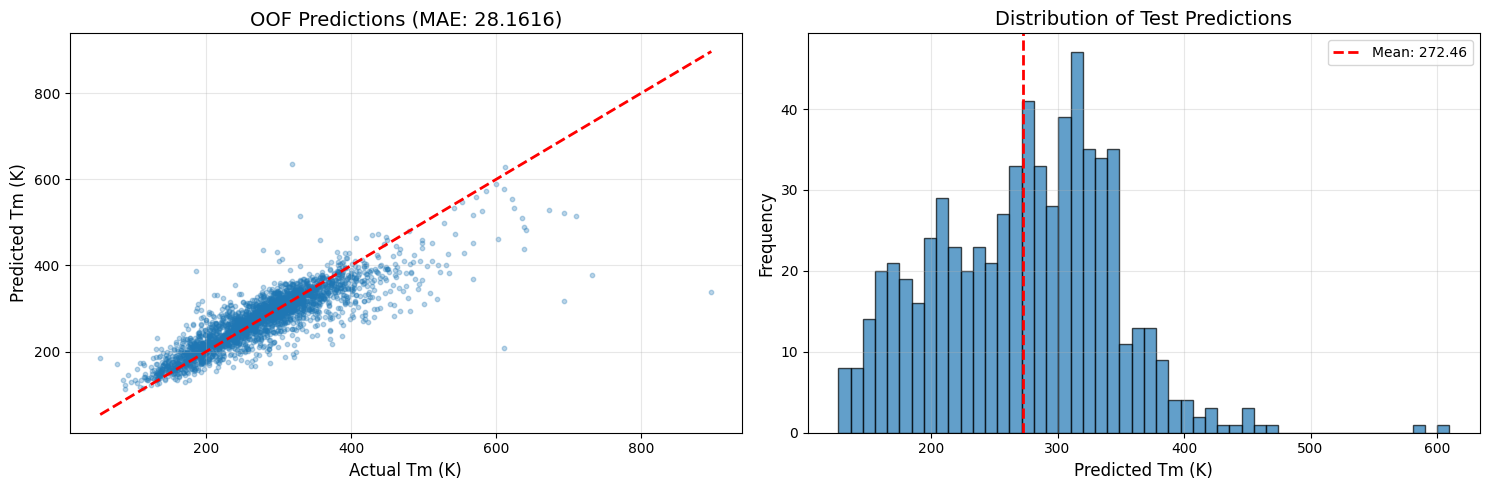

✅ Visualization complete!


In [11]:
# ================== VISUALIZE PREDICTIONS ==================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# OOF predictions vs actual
axes[0].scatter(y_train, oof_ensemble, alpha=0.3, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Tm (K)', fontsize=12)
axes[0].set_ylabel('Predicted Tm (K)', fontsize=12)
axes[0].set_title(f'OOF Predictions (MAE: {ensemble_mae_score:.4f})', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Distribution of test predictions
axes[1].hist(final_preds, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(final_preds.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {final_preds.mean():.2f}')
axes[1].set_xlabel('Predicted Tm (K)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Test Predictions', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")